In [187]:
import pandas as pd, warnings, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from scipy.stats import pearsonr

### Assign protein features to candidate proteins evaluated by reporter assay

In [196]:
warnings.filterwarnings('ignore')
deg_stats = pd.read_excel("/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/Deg_stats_final_pub.xlsx").drop(columns=['Unnamed: 0'])
ref = pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/Flow_well_keys_pub.xlsx')
pro_features = pd.read_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/union_ortho_table_withFeatures.csv').set_index('gene')

#Remove control strain rows from the deg_stats file
msm_filtered = deg_stats[deg_stats['Substrate']!='No Target'].copy()

# group strains by their deg constant
msm_filtered['Deg_group']=(msm_filtered['log2(Deg constant)'].values>-6)*1

# plate5 as validation set
msm_filtered['as_validation'] = [1 if x in ref[ref['Plate']=='Plate5']['Locus_tag'].unique() else 0 for x in msm_filtered['Locus']]

# import protein feature
numeric_feature_cols = list(pro_features.columns[25:])+['Msm_PI','Msm_Aliphatic_Index']
msm_filtered[numeric_feature_cols] = pro_features.loc[msm_filtered['Locus'].values,numeric_feature_cols].copy().values

### Save feature table

In [197]:
msm_filtered.to_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/reporter_assay_features.csv')

### Interrogate relationship between steady state protein/RNA ratio vs. degradability

In [198]:
rna = pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/20231107_Protein-RNA-corr.xlsx',
                    sheet_name='PMID_30957850_H37Rv_RPKM').set_index('Locus')
pro = pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/20231107_Protein-RNA-corr.xlsx',
                    sheet_name='PMID_26094805_protein_abundance').set_index('Locus')
rna['mean_rpkm'] = rna[rna.columns[:3]].values.mean(axis=1)
overlap = [x for x in np.unique(np.concatenate([rna.index,pro.index])) if x in rna.index and x in pro.index ]
subset = pro.loc[overlap].copy()
subset['mean_rpkm'] = rna.loc[overlap]['mean_rpkm'].values
subset['log2(rpkm)'] = np.log2(subset['mean_rpkm'].values+1)
subset['Pro/RNA'] = subset['Protein'].values/subset['mean_rpkm'] 
subset['log2(Pro/RNA)'] = np.log2(subset['Pro/RNA'].values)

In [199]:
pro_rna_avalable = [x for x,v in msm_filtered[['Locus','Mtb_ortholog']].values if v in subset.index]
filtered_reindexed = msm_filtered.set_index('Locus').copy().loc[pro_rna_avalable].copy()
filtered_reindexed['log2(Pro/RNA)'] = subset.loc[list(filtered_reindexed['Mtb_ortholog'].values)]['log2(Pro/RNA)'].values

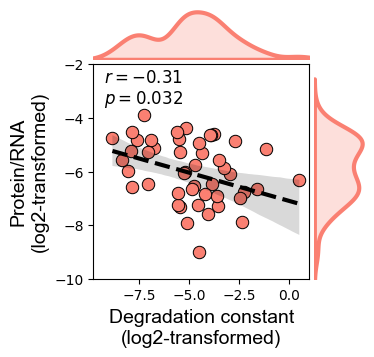

In [200]:
fig=plt.figure(figsize=(3.5,3.5))
grids = gs(5,5,hspace=0.1,wspace=0.1)
ax1 = fig.add_subplot(grids[0,:-1])
ax2 = fig.add_subplot(grids[1:,-1])
ax3 = fig.add_subplot(grids[1:,:-1])
sns.scatterplot(data=filtered_reindexed,
                x='log2(Deg constant)',
                y='log2(Pro/RNA)',ax=ax3,color='salmon',ec='black',s=80)
sns.regplot(data=filtered_reindexed,
                x='log2(Deg constant)',color='black',
                y='log2(Pro/RNA)',ax=ax3,scatter=False,line_kws={'lw':3,'ls':'--'})
sns.kdeplot(data=filtered_reindexed,x='log2(Deg constant)',ax=ax1,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
sns.kdeplot(data=filtered_reindexed,y='log2(Pro/RNA)',ax=ax2,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
ax3.set_ylim(-10,-2)
ax2.set_ylim(-10,-2)
ax3.set_xlim(-9.8,1)
ax1.set_xlim(-9.8,1)
ax1.axis('off')
ax2.axis('off')
ax3.set_xlabel('Degradation constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax3.set_ylabel('Protein/RNA\n(log2-transformed)',fontsize=14,fontname='Arial')
r,p = pearsonr(filtered_reindexed['log2(Deg constant)'],filtered_reindexed['log2(Pro/RNA)'])
ax3.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax3.transAxes,fontsize=12,fontname='Arial',ha='left')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_protein-rna-ratio_deg_corr.svg',
            bbox_inches='tight')